# 📌RNN & LSTM 실습

## 1. 기본 설정

In [92]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN

tf.keras.backend.set_floatx('float64')

In [121]:
train = pd.read_csv('train.csv', encoding='CP949')
test = pd.read_csv('test.csv', encoding='CP949')
submission = pd.read_csv('sample_submission.csv')

In [122]:
train = train[train['num']==2]

In [95]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
2040,2,2020-06-01 00,977.184,18.3,2.5,94.0,0.0,0.0,1.0,0.0
2041,2,2020-06-01 01,966.168,18.8,2.3,89.0,0.0,0.0,1.0,0.0
2042,2,2020-06-01 02,972.972,19.0,3.2,86.0,0.0,0.0,1.0,0.0
2043,2,2020-06-01 03,965.844,19.0,4.1,85.0,0.0,0.0,1.0,0.0
2044,2,2020-06-01 04,971.676,18.9,3.9,87.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4075,2,2020-08-24 19,1353.348,27.9,1.7,83.0,0.0,0.6,1.0,0.0
4076,2,2020-08-24 20,1260.036,27.4,1.4,83.0,0.0,0.0,1.0,0.0
4077,2,2020-08-24 21,1214.028,27.1,1.4,86.0,0.0,0.0,1.0,0.0
4078,2,2020-08-24 22,1126.224,26.9,0.0,84.0,0.0,0.0,1.0,0.0


## 2. 데이터 전처리 

In [96]:
# MinMax Scaling

mini = train.iloc[:,2].min()
size = train.iloc[:,2].max()-train.iloc[:,2].min()
train.iloc[:,2] = (train.iloc[:,2]-mini)/size

In [97]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
2040,2,2020-06-01 00,0.033729,18.3,2.5,94.0,0.0,0.0,1.0,0.0
2041,2,2020-06-01 01,0.024769,18.8,2.3,89.0,0.0,0.0,1.0,0.0
2042,2,2020-06-01 02,0.030303,19.0,3.2,86.0,0.0,0.0,1.0,0.0
2043,2,2020-06-01 03,0.024506,19.0,4.1,85.0,0.0,0.0,1.0,0.0
2044,2,2020-06-01 04,0.029249,18.9,3.9,87.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4075,2,2020-08-24 19,0.339657,27.9,1.7,83.0,0.0,0.6,1.0,0.0
4076,2,2020-08-24 20,0.263768,27.4,1.4,83.0,0.0,0.0,1.0,0.0
4077,2,2020-08-24 21,0.226350,27.1,1.4,86.0,0.0,0.0,1.0,0.0
4078,2,2020-08-24 22,0.154941,26.9,0.0,84.0,0.0,0.0,1.0,0.0


In [98]:
train_x = tf.reshape(train.iloc[:, 2].values, [24*85, 1])
print(f'train_x.shape:{train_x.shape}')

train_x.shape:(2040, 1)


In [99]:
train_x

<tf.Tensor: shape=(2040, 1), dtype=float64, numpy=
array([[0.03372859],
       [0.02476943],
       [0.03030303],
       ...,
       [0.22635046],
       [0.15494071],
       [0.13965744]])>

In [100]:
input_window = 996
output_window = 24
window = 12
num_features = 1

In [101]:
train_window_x = np.zeros(((train_x.shape[0]-(input_window + output_window))//window, input_window, num_features))
train_window_y = np.zeros(((train_x.shape[0]-(input_window + output_window))//window, output_window, num_features))
print(f'train_window_x.shape:{train_window_x.shape}')
print(f'train_window_y.shape:{train_window_y.shape}')

train_window_x.shape:(85, 996, 1)
train_window_y.shape:(85, 24, 1)


In [102]:
for start in range(0, train_x.shape[0]-(input_window+output_window), window):
    end = start+input_window
    train_window_x[start//window, :] = train_x[start: end               , :]
    train_window_y[start//window, :] = train_x[end  : end+ output_window, :]

In [103]:
train_window_x

array([[[0.03372859],
        [0.02476943],
        [0.03030303],
        ...,
        [0.10461133],
        [0.10250329],
        [0.11146245]],

       [[0.51330698],
        [0.52068511],
        [0.51831357],
        ...,
        [0.06113307],
        [0.0513834 ],
        [0.04295125]],

       [[0.0458498 ],
        [0.02134387],
        [0.02714097],
        ...,
        [0.57496706],
        [0.54808959],
        [0.54940711]],

       ...,

       [[0.02977602],
        [0.01976285],
        [0.01949934],
        ...,
        [0.26403162],
        [0.23847167],
        [0.24084321]],

       [[0.12305665],
        [0.11251647],
        [0.10777339],
        ...,
        [0.09960474],
        [0.07299078],
        [0.07009223]],

       [[0.0397892 ],
        [0.03399209],
        [0.03478261],
        ...,
        [0.15810277],
        [0.16363636],
        [0.14888011]]])

In [104]:
train_window_y

array([[[0.12305665],
        [0.11251647],
        [0.10777339],
        ...,
        [0.57496706],
        [0.54808959],
        [0.54940711]],

       [[0.0397892 ],
        [0.03399209],
        [0.03478261],
        ...,
        [0.10961792],
        [0.05032938],
        [0.02898551]],

       [[0.59367589],
        [0.56600791],
        [0.55573123],
        ...,
        [0.55704875],
        [0.54914361],
        [0.54123847]],

       ...,

       [[0.25006588],
        [0.25849802],
        [0.26508564],
        ...,
        [0.15810277],
        [0.16363636],
        [0.14888011]],

       [[0.06060606],
        [0.05480896],
        [0.04901186],
        ...,
        [0.11778656],
        [0.10645586],
        [0.10988142]],

       [[0.16100132],
        [0.17628458],
        [0.19736495],
        ...,
        [0.89512516],
        [0.88379447],
        [0.88801054]]])

## 3. RNN

tf.random.set_seed(0)

model = Sequential()
model.add(SimpleRNN(rnn_units, return_sequences=False))
model.add(Dense(output_window * num_features, kernel_initializer=tf.initializers.zeros())) 

model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

histroy = model.fit(data_mm_train_x, data_mm_train_y, epochs=800, batch_size=128, validation_split = 0.2,
                    callbacks=[early_stop, reduceLR])

model.summary()

## 4. LSTM 

In [105]:
tf.random.set_seed(0)

model = Sequential([
    LSTM(32, return_sequences=False, recurrent_dropout=0.2),
    Dense(output_window*1, kernel_initializer=tf.initializers.zeros()),
    Reshape([output_window, 1])
])
                   
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')

save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="lstm_model.h5", monitor='val_loss', save_best_only=True)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# 검증 손실이 10epoch 동안 좋아지지 않으면 학습률을 0.1 배로 재구성
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50)         

In [106]:
model.fit(train_window_x, train_window_y, epochs=500, batch_size=128, validation_split=0.2, verbose=1,
         callbacks=[PrintDot(), early_stop, save_best_only, reduceLR])
model.summary()

Epoch 1/500
1/1 [==============================] - 1s 733ms/step - loss: 0.3155 - mae: 0.3155 - val_loss: 0.3182 - val_mae: 0.3182
Epoch 2/500
1/1 [==============================] - 0s 260ms/step - loss: 0.3089 - mae: 0.3089 - val_loss: 0.3113 - val_mae: 0.3113
Epoch 3/500
1/1 [==============================] - 0s 153ms/step - loss: 0.3023 - mae: 0.3023 - val_loss: 0.3025 - val_mae: 0.3025
Epoch 4/500
1/1 [==============================] - 0s 233ms/step - loss: 0.2938 - mae: 0.2938 - val_loss: 0.2894 - val_mae: 0.2894
Epoch 5/500
1/1 [==============================] - 0s 137ms/step - loss: 0.2823 - mae: 0.2823 - val_loss: 0.2677 - val_mae: 0.2677
Epoch 6/500
1/1 [==============================] - 0s 148ms/step - loss: 0.2653 - mae: 0.2653 - val_loss: 0.2349 - val_mae: 0.2349
Epoch 7/500
1/1 [==============================] - 0s 137ms/step - loss: 0.2422 - mae: 0.2422 - val_loss: 0.2129 - val_mae: 0.2129
Epoch 8/500
1/1 [==============================] - 0s 128ms/step - loss: 0.2284 - m

Epoch 60/500
1/1 [==============================] - 0s 229ms/step - loss: 0.1414 - mae: 0.1414 - val_loss: 0.1486 - val_mae: 0.1486
Epoch 61/500
1/1 [==============================] - 0s 162ms/step - loss: 0.1403 - mae: 0.1403 - val_loss: 0.1540 - val_mae: 0.1540
Epoch 62/500
1/1 [==============================] - 0s 128ms/step - loss: 0.1398 - mae: 0.1398 - val_loss: 0.1486 - val_mae: 0.1486
Epoch 63/500
1/1 [==============================] - 0s 122ms/step - loss: 0.1341 - mae: 0.1341 - val_loss: 0.1500 - val_mae: 0.1500
Epoch 64/500
1/1 [==============================] - 0s 159ms/step - loss: 0.1297 - mae: 0.1297 - val_loss: 0.1464 - val_mae: 0.1464
Epoch 65/500
1/1 [==============================] - 0s 127ms/step - loss: 0.1270 - mae: 0.1270 - val_loss: 0.1467 - val_mae: 0.1467
Epoch 66/500
1/1 [==============================] - 0s 140ms/step - loss: 0.1243 - mae: 0.1243 - val_loss: 0.1473 - val_mae: 0.1473
Epoch 67/500
1/1 [==============================] - 0s 138ms/step - loss: 0.

1/1 [==============================] - 0s 130ms/step - loss: 0.0934 - mae: 0.0934 - val_loss: 0.1272 - val_mae: 0.1272
Epoch 177/500
1/1 [==============================] - 0s 146ms/step - loss: 0.0945 - mae: 0.0945 - val_loss: 0.1175 - val_mae: 0.1175
Epoch 178/500
1/1 [==============================] - 0s 140ms/step - loss: 0.0921 - mae: 0.0921 - val_loss: 0.1242 - val_mae: 0.1242
Epoch 179/500
1/1 [==============================] - 0s 151ms/step - loss: 0.0942 - mae: 0.0942 - val_loss: 0.1169 - val_mae: 0.1169
Epoch 180/500
1/1 [==============================] - 0s 141ms/step - loss: 0.0971 - mae: 0.0971 - val_loss: 0.1231 - val_mae: 0.1231
Epoch 181/500
1/1 [==============================] - 0s 139ms/step - loss: 0.0915 - mae: 0.0915 - val_loss: 0.1169 - val_mae: 0.1169
Epoch 182/500
1/1 [==============================] - 0s 168ms/step - loss: 0.0922 - mae: 0.0922 - val_loss: 0.1205 - val_mae: 0.1205
Epoch 183/500
1/1 [==============================] - 0s 155ms/step - loss: 0.0925 -

1/1 [==============================] - 0s 174ms/step - loss: 0.0848 - mae: 0.0848 - val_loss: 0.1103 - val_mae: 0.1103
Epoch 293/500
1/1 [==============================] - 0s 133ms/step - loss: 0.0880 - mae: 0.0880 - val_loss: 0.1040 - val_mae: 0.1040
Epoch 294/500
1/1 [==============================] - 0s 136ms/step - loss: 0.0866 - mae: 0.0866 - val_loss: 0.1122 - val_mae: 0.1122
Epoch 295/500
1/1 [==============================] - 0s 139ms/step - loss: 0.0868 - mae: 0.0868 - val_loss: 0.1037 - val_mae: 0.1037
Epoch 296/500
1/1 [==============================] - 0s 130ms/step - loss: 0.0855 - mae: 0.0855 - val_loss: 0.1117 - val_mae: 0.1117
Epoch 297/500
1/1 [==============================] - 0s 144ms/step - loss: 0.0880 - mae: 0.0880 - val_loss: 0.1025 - val_mae: 0.1025
Epoch 298/500
1/1 [==============================] - 0s 134ms/step - loss: 0.0880 - mae: 0.0880 - val_loss: 0.1097 - val_mae: 0.1097
Epoch 299/500
1/1 [==============================] - 0s 170ms/step - loss: 0.0864 -

Epoch 351/500
1/1 [==============================] - 0s 181ms/step - loss: 0.0803 - mae: 0.0803 - val_loss: 0.0929 - val_mae: 0.0929
Epoch 352/500
1/1 [==============================] - 0s 131ms/step - loss: 0.0819 - mae: 0.0819 - val_loss: 0.0953 - val_mae: 0.0953
Epoch 353/500
1/1 [==============================] - 0s 151ms/step - loss: 0.0780 - mae: 0.0780 - val_loss: 0.0941 - val_mae: 0.0941
Epoch 354/500
1/1 [==============================] - 0s 128ms/step - loss: 0.0857 - mae: 0.0857 - val_loss: 0.0955 - val_mae: 0.0955
Epoch 355/500
1/1 [==============================] - 0s 190ms/step - loss: 0.0825 - mae: 0.0825 - val_loss: 0.0913 - val_mae: 0.0913
Epoch 356/500
1/1 [==============================] - 0s 134ms/step - loss: 0.0805 - mae: 0.0805 - val_loss: 0.0949 - val_mae: 0.0949
Epoch 357/500
1/1 [==============================] - 0s 211ms/step - loss: 0.0789 - mae: 0.0789 - val_loss: 0.0907 - val_mae: 0.0907
Epoch 358/500
1/1 [==============================] - 0s 154ms/step - 

In [107]:
new_test_x = tf.reshape(train.iloc[:, 2].values, [1, 24*85, 1])
print(f'train_x.shape:{new_test_x.shape}')

train_x.shape:(1, 2040, 1)


In [108]:
prediction = np.zeros((1, 168, 1))

for i in range(168//output_window):
    start_ = i*output_window
    next_ = model.predict(new_test_x[ : , -input_window:, :])
    new_test_x = tf.concat([new_test_x, next_], axis=1)
    print(new_test_x.shape)
    prediction[:, start_: start_ + output_window, :]= next_
prediction = prediction *size + mini

(1, 2064, 1)
(1, 2088, 1)
(1, 2112, 1)
(1, 2136, 1)
(1, 2160, 1)
(1, 2184, 1)
(1, 2208, 1)


In [109]:
submission = submission.iloc[:168, :]

In [110]:
submission['answer'] = prediction.reshape([-1,1])
submission

,num_date_time,answer
0,1 2020-08-25 00,1087.074550
1,1 2020-08-25 01,1078.535301
2,1 2020-08-25 02,1072.770107
3,1 2020-08-25 03,1058.060552
4,1 2020-08-25 04,1055.692050
...,...,...
163,1 2020-08-31 19,1267.514787
164,1 2020-08-31 20,1166.785842
165,1 2020-08-31 21,1112.096658
166,1 2020-08-31 22,1073.300374


In [111]:
train = pd.read_csv('train.csv', encoding = 'CP949')
building2 = train.iloc[2040:4080,:]

a = list(range(2040, 2208))
submission.index = a

In [112]:
building2.reset_index(inplace=True)
building2 = building2.drop(['index'], axis=1)
building2

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,2,2020-06-01 00,977.184,18.3,2.5,94.0,0.0,0.0,1.0,0.0
1,2,2020-06-01 01,966.168,18.8,2.3,89.0,0.0,0.0,1.0,0.0
2,2,2020-06-01 02,972.972,19.0,3.2,86.0,0.0,0.0,1.0,0.0
3,2,2020-06-01 03,965.844,19.0,4.1,85.0,0.0,0.0,1.0,0.0
4,2,2020-06-01 04,971.676,18.9,3.9,87.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2035,2,2020-08-24 19,1353.348,27.9,1.7,83.0,0.0,0.6,1.0,0.0
2036,2,2020-08-24 20,1260.036,27.4,1.4,83.0,0.0,0.0,1.0,0.0
2037,2,2020-08-24 21,1214.028,27.1,1.4,86.0,0.0,0.0,1.0,0.0
2038,2,2020-08-24 22,1126.224,26.9,0.0,84.0,0.0,0.0,1.0,0.0


In [113]:
R2 = building2['전력사용량(kWh)']
P2 = submission['answer']

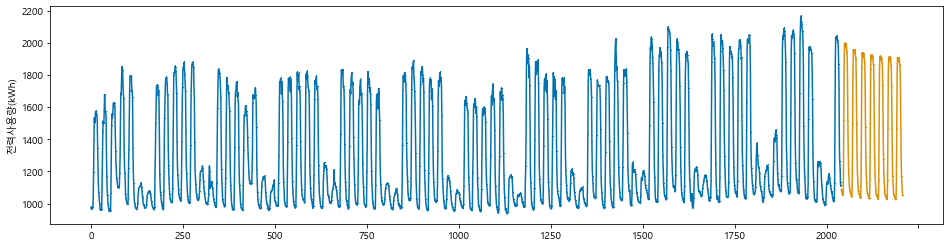

In [116]:
plt.rc('font', family='Malgun Gothic')

plot_series(R2, P2, markers=[',' , ','])
plt.show()

## 5. 튜닝용

In [192]:
tf.random.set_seed(0)

model = Sequential([
    LSTM(32, return_sequences=False, recurrent_dropout=0.2),
    Dense(output_window*1, kernel_initializer=tf.initializers.zeros()),
    Reshape([output_window, 1])
])
                   
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')

save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="lstm_model.h5", monitor='val_loss', save_best_only=True)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# 검증 손실이 50epoch 동안 좋아지지 않으면 학습률을 0.1 배로 재구성
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50)         

In [193]:
model.fit(train_window_x, train_window_y, epochs=500, batch_size=64, validation_split=0.2, verbose=1,
         callbacks=[PrintDot(), early_stop, save_best_only, reduceLR])
model.summary()

Epoch 1/500
2/2 [==============================] - 9s 4s/step - loss: 0.3151 - mae: 0.3151 - val_loss: 0.3111 - val_mae: 0.3111
Epoch 2/500
2/2 [==============================] - 2s 1s/step - loss: 0.3015 - mae: 0.3015 - val_loss: 0.2901 - val_mae: 0.2901
Epoch 3/500
2/2 [==============================] - 2s 1s/step - loss: 0.2820 - mae: 0.2820 - val_loss: 0.2407 - val_mae: 0.2407
Epoch 4/500
2/2 [==============================] - 2s 1s/step - loss: 0.2450 - mae: 0.2450 - val_loss: 0.2151 - val_mae: 0.2151
Epoch 5/500
2/2 [==============================] - 3s 2s/step - loss: 0.2287 - mae: 0.2287 - val_loss: 0.2201 - val_mae: 0.2201
Epoch 6/500
2/2 [==============================] - 2s 1s/step - loss: 0.2312 - mae: 0.2312 - val_loss: 0.2180 - val_mae: 0.2180
Epoch 7/500
2/2 [==============================] - 3s 2s/step - loss: 0.2284 - mae: 0.2284 - val_loss: 0.2122 - val_mae: 0.2122
Epoch 8/500
2/2 [==============================] - 3s 1s/step - loss: 0.2266 - mae: 0.2266 - val_loss: 0

Epoch 61/500
2/2 [==============================] - 3s 1s/step - loss: 0.1273 - mae: 0.1273 - val_loss: 0.1550 - val_mae: 0.1550
Epoch 62/500
2/2 [==============================] - 2s 1s/step - loss: 0.1255 - mae: 0.1255 - val_loss: 0.1514 - val_mae: 0.1514
Epoch 63/500
2/2 [==============================] - 2s 1s/step - loss: 0.1174 - mae: 0.1174 - val_loss: 0.1597 - val_mae: 0.1597
Epoch 64/500
2/2 [==============================] - 3s 1s/step - loss: 0.1347 - mae: 0.1347 - val_loss: 0.1463 - val_mae: 0.1463
Epoch 65/500
2/2 [==============================] - 3s 1s/step - loss: 0.1252 - mae: 0.1252 - val_loss: 0.1490 - val_mae: 0.1490
Epoch 66/500
2/2 [==============================] - 3s 1s/step - loss: 0.1183 - mae: 0.1183 - val_loss: 0.1435 - val_mae: 0.1435
Epoch 67/500
2/2 [==============================] - 3s 1s/step - loss: 0.1146 - mae: 0.1146 - val_loss: 0.1528 - val_mae: 0.1528
Epoch 68/500
2/2 [==============================] - 3s 1s/step - loss: 0.1293 - mae: 0.1293 - val

2/2 [==============================] - 1s 631ms/step - loss: 0.1003 - mae: 0.1003 - val_loss: 0.1404 - val_mae: 0.1404
Epoch 121/500
2/2 [==============================] - 2s 1s/step - loss: 0.1097 - mae: 0.1097 - val_loss: 0.1261 - val_mae: 0.1261
Epoch 122/500
2/2 [==============================] - 2s 868ms/step - loss: 0.0978 - mae: 0.0978 - val_loss: 0.1278 - val_mae: 0.1278
Epoch 123/500
2/2 [==============================] - 2s 788ms/step - loss: 0.1029 - mae: 0.1029 - val_loss: 0.1245 - val_mae: 0.1245
Epoch 124/500
2/2 [==============================] - 1s 636ms/step - loss: 0.0995 - mae: 0.0995 - val_loss: 0.1265 - val_mae: 0.1265
Epoch 125/500
2/2 [==============================] - 1s 725ms/step - loss: 0.1008 - mae: 0.1008 - val_loss: 0.1373 - val_mae: 0.1373
Epoch 126/500
2/2 [==============================] - 1s 748ms/step - loss: 0.1194 - mae: 0.1194 - val_loss: 0.1309 - val_mae: 0.1309
Epoch 127/500
2/2 [==============================] - 2s 755ms/step - loss: 0.0988 - ma

2/2 [==============================] - 1s 703ms/step - loss: 0.0939 - mae: 0.0939 - val_loss: 0.1253 - val_mae: 0.1253
Epoch 179/500
2/2 [==============================] - 1s 596ms/step - loss: 0.1092 - mae: 0.1092 - val_loss: 0.1133 - val_mae: 0.1133
Epoch 180/500
2/2 [==============================] - 2s 765ms/step - loss: 0.0932 - mae: 0.0932 - val_loss: 0.1132 - val_mae: 0.1132
Epoch 181/500
2/2 [==============================] - 1s 563ms/step - loss: 0.0929 - mae: 0.0929 - val_loss: 0.1304 - val_mae: 0.1304
Epoch 182/500
2/2 [==============================] - 2s 822ms/step - loss: 0.1047 - mae: 0.1047 - val_loss: 0.1147 - val_mae: 0.1147
Epoch 183/500
2/2 [==============================] - 1s 690ms/step - loss: 0.0968 - mae: 0.0968 - val_loss: 0.1191 - val_mae: 0.1191
Epoch 184/500
2/2 [==============================] - 1s 591ms/step - loss: 0.1000 - mae: 0.1000 - val_loss: 0.1120 - val_mae: 0.1120
Epoch 185/500
2/2 [==============================] - 1s 621ms/step - loss: 0.0915 -

2/2 [==============================] - 1s 628ms/step - loss: 0.0901 - mae: 0.0901 - val_loss: 0.1213 - val_mae: 0.1213
Epoch 237/500
2/2 [==============================] - 1s 574ms/step - loss: 0.0951 - mae: 0.0951 - val_loss: 0.1114 - val_mae: 0.1114
Epoch 238/500
2/2 [==============================] - 1s 580ms/step - loss: 0.0971 - mae: 0.0971 - val_loss: 0.1048 - val_mae: 0.1048
Epoch 239/500
2/2 [==============================] - 1s 511ms/step - loss: 0.0898 - mae: 0.0898 - val_loss: 0.1082 - val_mae: 0.1082
Epoch 240/500
2/2 [==============================] - 1s 733ms/step - loss: 0.0917 - mae: 0.0917 - val_loss: 0.1139 - val_mae: 0.1139
Epoch 241/500
2/2 [==============================] - 1s 553ms/step - loss: 0.0905 - mae: 0.0905 - val_loss: 0.1105 - val_mae: 0.1105
Epoch 242/500
2/2 [==============================] - 1s 596ms/step - loss: 0.0900 - mae: 0.0900 - val_loss: 0.1204 - val_mae: 0.1204
Epoch 243/500
2/2 [==============================] - 1s 605ms/step - loss: 0.0938 -

2/2 [==============================] - 1s 660ms/step - loss: 0.0904 - mae: 0.0904 - val_loss: 0.1123 - val_mae: 0.1123
Epoch 295/500
2/2 [==============================] - 1s 525ms/step - loss: 0.0903 - mae: 0.0903 - val_loss: 0.1088 - val_mae: 0.1088
Epoch 296/500
2/2 [==============================] - 1s 648ms/step - loss: 0.0934 - mae: 0.0934 - val_loss: 0.1085 - val_mae: 0.1085
Epoch 297/500
2/2 [==============================] - 1s 529ms/step - loss: 0.0864 - mae: 0.0864 - val_loss: 0.1197 - val_mae: 0.1197
Epoch 298/500
2/2 [==============================] - 1s 744ms/step - loss: 0.0964 - mae: 0.0964 - val_loss: 0.1049 - val_mae: 0.1049
Epoch 299/500
2/2 [==============================] - 1s 529ms/step - loss: 0.0854 - mae: 0.0854 - val_loss: 0.1073 - val_mae: 0.1073
Epoch 300/500
2/2 [==============================] - 1s 747ms/step - loss: 0.0890 - mae: 0.0890 - val_loss: 0.1127 - val_mae: 0.1127
Epoch 301/500
2/2 [==============================] - 1s 643ms/step - loss: 0.0892 -

In [194]:
train = pd.read_csv('train.csv', encoding='CP949')
train = train[train['num']==2]

new_test_x = tf.reshape(train.iloc[:, 2].values, [1, 24*85, 1])
print(f'train_x.shape:{new_test_x.shape}')

train_x.shape:(1, 2040, 1)


In [195]:
prediction = np.zeros((1, 168, 1))

for i in range(168//output_window):
    start_ = i*output_window
    next_ = model.predict(new_test_x[ : , -input_window:, :])
    new_test_x = tf.concat([new_test_x, next_], axis=1)
    print(new_test_x.shape)
    prediction[:, start_: start_ + output_window, :]= next_
prediction = prediction *size + mini

(1, 2064, 1)
(1, 2088, 1)
(1, 2112, 1)
(1, 2136, 1)
(1, 2160, 1)
(1, 2184, 1)
(1, 2208, 1)


In [196]:
submission = submission.iloc[:168, :]

In [197]:
submission['answer'] = prediction.reshape([-1,1])
submission

,num_date_time,answer
2040,1 2020-08-25 00,2802.724790
2041,1 2020-08-25 01,2783.264414
2042,1 2020-08-25 02,2754.316585
2043,1 2020-08-25 03,2693.462961
2044,1 2020-08-25 04,2646.091385
...,...,...
2203,1 2020-08-31 19,1515.831593
2204,1 2020-08-31 20,1858.948721
2205,1 2020-08-31 21,1967.965826
2206,1 2020-08-31 22,1952.585771


In [198]:
train = pd.read_csv('train.csv', encoding = 'CP949')
building2 = train.iloc[2040:4080,:]

a = list(range(2040, 2208))
submission.index = a

In [199]:
building2.reset_index(inplace=True)
building2 = building2.drop(['index'], axis=1)
building2

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,2,2020-06-01 00,977.184,18.3,2.5,94.0,0.0,0.0,1.0,0.0
1,2,2020-06-01 01,966.168,18.8,2.3,89.0,0.0,0.0,1.0,0.0
2,2,2020-06-01 02,972.972,19.0,3.2,86.0,0.0,0.0,1.0,0.0
3,2,2020-06-01 03,965.844,19.0,4.1,85.0,0.0,0.0,1.0,0.0
4,2,2020-06-01 04,971.676,18.9,3.9,87.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2035,2,2020-08-24 19,1353.348,27.9,1.7,83.0,0.0,0.6,1.0,0.0
2036,2,2020-08-24 20,1260.036,27.4,1.4,83.0,0.0,0.0,1.0,0.0
2037,2,2020-08-24 21,1214.028,27.1,1.4,86.0,0.0,0.0,1.0,0.0
2038,2,2020-08-24 22,1126.224,26.9,0.0,84.0,0.0,0.0,1.0,0.0


In [200]:
R2 = building2['전력사용량(kWh)']
P2 = submission['answer']

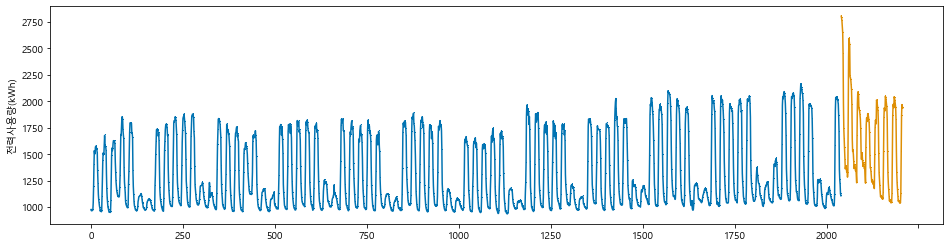

In [201]:
plt.rc('font', family='Malgun Gothic')

plot_series(R2, P2, markers=[',' , ','])
plt.show()